# Proportional Integral(PI) Controller
The value of the controller output $u(t)$  is fed into the system as the manipulated variable input.
$$e(t) = SP-PV$$
$$u(t) = u_{bias} + K_c \, e(t) + \frac{K_c}{\tau_I}\int_0^t e(t)dt$$
$$u(t) = u_{bias} + K_c \, e(t) + \frac{K_c}{\tau_I}\sum_{i=1}^{n_t} e_i(t)\Delta t$$
The $u_{bias}$ term is a constant that is typically set to the value of $u(t)$ when the controller is first switched from manual to automatic mode. This gives "bumpless" transfer if the error is zero when the controller is turned on.

PI control is needed for non-integrating processes, meaning any process that eventually returns to the same output given the same set of inputs and disturbances.

Integral action is used to remove offset and can be thought of as an adjustable $u_{bias}$

## Tuning Correlations:
#### IMC(Internal Model Control) Tuning Correlations:
$$\mathrm{Aggressive\,Tuning:} \quad \tau_c = \max \left( 0.1 \tau_p, 0.8 \theta_p \right)$$
$$\mathrm{Moderate\,Tuning:} \quad \tau_c = \max \left( 1.0 \tau_p, 8.0 \theta_p \right)$$
$$\mathrm{Conservative\,Tuning:} \quad \tau_c = \max \left( 10.0 \tau_p, 80.0 \theta_p \right)$$
$$K_c = \frac{1}{K_p}\frac{\tau_p}{\left( \theta_p + \tau_c \right)} \quad \quad \tau_I = \tau_p$$

Note that with moderate tuning and negligible dead-time $(\theta_p -> 0  \ and \  \tau_c = 1.0 \tau_p)$, IMC reduces to simple tuning correlations that are easy to recall without a reference book.
$$K_c = \frac{1}{K_p} \quad \quad \tau_I = \tau_p \quad \quad \mathrm{Simple\,tuning\,correlations}$$

#### ITAE(Integral of Time-weighted Absolute Error) Tuning Correlations:
$$K_c = \frac{0.586}{K_p}\left(\frac{\theta_p}{\tau_p}\right)^{-0.916} \quad \tau_I = \frac{\tau_p}{1.03-0.165\left(\theta_p/\tau_p\right)}\quad\mathrm{Set\;point\;tracking(Servo \ control)}$$
$$K_c = \frac{0.859}{K_p}\left(\frac{\theta_p}{\tau_p}\right)^{-0.977} \quad \tau_I = \frac{\tau_p}{0.674}\left(\frac{\theta_p}{\tau_p}\right)^{0.680}\quad\mathrm{Disturbance\;rejection(Regulatory \ control)}$$

## Anti-Reset Windup:
An important feature of a controller with an integral term is to consider the case where the controller output $u(t)$ saturates at an upper or lower bound for an extended period of time. This causes the integral term to accumulate to a large summation that causes the controller to stay at the saturation limit until the integral summation is reduced. Anti-reset windup is that the integral term does not accumulate if the controller output is saturated at an upper or lower limit.




## Assignment: Automobile Velocity Control
A self-driving car company has requested a speed controller for their new model of electric autonomous vehicles. Unlike standard cruise control systems, this speed controller must manage transitions between all velocities ranging from 0 to 25 m/s (56 mph or 90 km/hr).
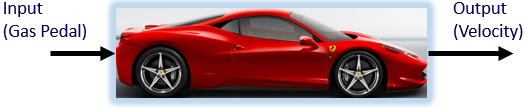
Regenerative braking is part of this application by allowing the gas pedal to go from -50% to 100%.

#### Process Equation:
$$m\frac{dv(t)}{dt} = F_p u(t) - \frac{1}{2} \rho \, A \, C_d v(t)^2$$
with u(t) as gas pedal position (%pedal), v(t) as velocity (m/s), m as the mass of the vehicle (500 kg) plus the mass of the passengers and cargo (200 kg), Cd as the drag coefficient (0.24),$\rho$ as the air density (1.225 kg/m3), A as the vehicle cross-sectional area (5 m2), and Fp as the thrust parameter (30 N/%pedal).

#### Steps to Follow:
    1.Simulating Model
    2.FOPDT
    3.PI Tuning
    4.Simulating PI

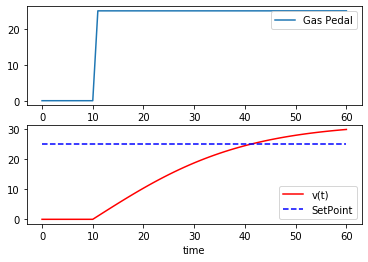

In [71]:
#Simulating Model
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
%matplotlib inline

def car(v,t,u,load):
    Cd = 0.24
    rho = 1.225
    m = 500
    A = 5
    Fp = 30
    dvdt = (Fp*u - (rho*A*Cd*(v**2))/2)/(m + load)
    return dvdt

def simModel():
    #Time span
    t = np.linspace(0,60,61)
    delta_t = t[1]-t[0]

    #Initial constants
    load = 200
    v0 = 0

    #Storing Gas-Peddal Responses
    step = np.zeros(len(t))
    #Step-Adding through Gas Peddal
    step[11:] = 25

    #Storing velocity responses
    v = np.ones(len(t))*v0

    #Simulating Model
    for i in range(len(t)-1):
        time = t[i:i+2]
        u = step[i+1]
        #Regenerative Breaking
        if u>=100:
            u = 100
        elif u<=-50:
            u = -50
        y = odeint(car, v0, time, args=(u, load))
        v0 = y[-1]
        v[i+1] = v0

    #Plotting
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(t, step, label='Gas Pedal')
    plt.legend(loc='best')
    plt.subplot(2,1,2)
    plt.plot(t, v, 'r-', label='v(t)')
    plt.plot(t, np.ones(len(t))*25, 'b--', label='SetPoint')
    plt.xlabel('time')
    plt.legend()
    plt.show()

simModel()

##### FOPDT
By analysing the above graph we find that:
1. $K_p$ = 1.2
2. $\theta_p$ = 0
3. $\tau_p$ = 20

##### PI Tuning
Using IMC Moderate tuning we get:
1. $\tau_I = \tau_p = 20$
2. $K_c = 1/K_p = 1/1.2$

In [72]:
#Simulating PID
def PI(v, SP, sum_int, delta_t=1, Kc=1/1.2, tauI=20, ubias=0.0):
    error = SP - v
    sum_int = sum_int + error*delta_t
    u = ubias + Kc*error + (Kc*sum_int)/tauI
    return u, error, sum_int

def simModelPI(Kc=1/1.2, tauI=20, ubias=0.0):
    #Time span
    t = np.linspace(0,300,301)
    delta_t = t[1]-t[0]
    
    #Initial constants
    load = 200
    v0 = 0
    
    #Step-Adding through set points(of velocity)
    SP = np.ones(len(t))*25
    SP[50: 100] = 0
    SP[100: 150] = 15
    SP[150: 200] = 20
    SP[200: ] = 10
    
    #Storing velocity responses
    v = np.ones(len(t))*v0

    #Storing Gas-Peddal(u) responses
    step = np.zeros(len(t))

    #Storing propotional error responses
    er = np.zeros(len(t))
    #Storing integral error responses
    ier = np.zeros(len(t))

    #Simulating PID+Model
    sum_int = 0
    for i in range(len(t)-1):
        time=t[i:i+2]
        u, error, sum_int = PI(v0, SP[i+1], sum_int, delta_t, Kc, tauI, ubias)
        #Regenerative Breaking and Anti-Reset Wrapup
        if u>=100:
            u = 100
            sum_int = sum_int - error*delta_t
        elif u<=-50:
            u = -50
            sum_int = sum_int - error*delta_t
        er[i+1] = error
        ier[i+1] = sum_int
        step[i+1] = u
        y = odeint(car, v0, time, args=(u, load))
        v0 = y[-1]
        v[i+1] = v0

    #Plotting
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(4,1,1)
    plt.plot(t,v,'r-', label='v(t)')
    plt.plot(t,SP,'b--', label='Set Point')
    plt.legend(loc='best')
    plt.ylabel('Velocity')

    plt.subplot(4,1,2)
    plt.plot(t, step, 'r-', label='u(t)')
    plt.legend(loc='best')
    plt.ylabel('Gas Peddal')


    plt.subplot(4,1,3)
    plt.plot(t, er, 'g:')
    plt.ylabel('Proportional error')

    plt.subplot(4,1,4)
    plt.plot(t, er, 'r:')
    plt.ylabel('Integral Error')
    plt.xlabel('Time')
    plt.show()
#simModelPI()

In [73]:
interactive_plot = interactive(simModelPI, Kc=(-5.0,10.0), tauI=(-10.0,50.0), biasu=(-1.0,5.0))
interactive_plot

interactive(children=(FloatSlider(value=0.8333333333333334, description='Kc', max=10.0, min=-5.0), FloatSlider…